## Post_Analysis1
This notebook analyzes prediction results. Note that target dams are selected by threshold of the Degree of Regulation (DOR) from the beggining.

In [1]:
import os
import numpy as np
import pandas as pd
import geopandas as gpd
import matplotlib as mpl
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import matplotlib.colors as colors
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import seaborn as sns
from scipy import stats
import HydroErr as he
from tools import save_hdf
from itertools import compress

In [2]:
# Load Dam Inflow data from SUTD
dfFlowDams = pd.read_hdf('./data/dfFlowDams.hdf')
ind_dams = np.load('./data/ind_dams.npz')['ind_dams']
# Load Degree of Regulation (DOR)
dor = pd.read_hdf('./data/new_dor.hdf')      # The order is sorted during the process
dam_dor = dor.loc[dor.DOR2 <= 0, 'GRAND_ID']
# Select only headwater dams (735)
idx_dor = np.isin(ind_dams[0,:], dam_dor)
damList = ind_dams[0,idx_dor]
ind_dams = ind_dams[1,idx_dor]
ndam = len(damList)

In [3]:
# Load prediction output files
mp1=[]; mp2=[]; mp3=[]; mp4=[]; mp5=[]; mp6=[]; mp7=[];
for i in range(1593):
    # Multiple file results
    filn = './data/chtc_out/dfFlowDams{}_manu.npz'.format(i)
    mp1.extend(np.load(filn,allow_pickle=True)['mp1'].tolist())
    mp2.extend(np.load(filn,allow_pickle=True)['mp2'].tolist())
    mp3.extend(np.load(filn,allow_pickle=True)['mp3'].tolist())
    mp4.extend(np.load(filn,allow_pickle=True)['mp4'].tolist())
    mp5.extend(np.load(filn,allow_pickle=True)['mp5'].tolist())
    mp6.extend(np.load(filn,allow_pickle=True)['mp6'].tolist())
    mp7.extend(np.load(filn,allow_pickle=True)['mp7'].tolist())
# Load predicted time-series and isFcst signs
dfMP1 = pd.read_hdf('./data/prediction/dfMP1.hdf')
dfMP2 = pd.read_hdf('./data/prediction/dfMP2.hdf')
dfMP3 = pd.read_hdf('./data/prediction/dfMP3.hdf')
dfMP4 = pd.read_hdf('./data/prediction/dfMP4.hdf')
dfMP5 = pd.read_hdf('./data/prediction/dfMP5.hdf')
dfMP6 = pd.read_hdf('./data/prediction/dfMP6.hdf')
dfMP7 = pd.read_hdf('./data/prediction/dfMP7.hdf')
dfMP1_sign = pd.read_hdf('./data/prediction/dfMP1_sign.hdf')
dfMP2_sign = pd.read_hdf('./data/prediction/dfMP2_sign.hdf')
dfMP3_sign = pd.read_hdf('./data/prediction/dfMP3_sign.hdf')
dfMP4_sign = pd.read_hdf('./data/prediction/dfMP4_sign.hdf')
dfMP5_sign = pd.read_hdf('./data/prediction/dfMP5_sign.hdf')
dfMP6_sign = pd.read_hdf('./data/prediction/dfMP6_sign.hdf')
dfMP7_sign = pd.read_hdf('./data/prediction/dfMP7_sign.hdf')
print('All results are loaded.')

/Users/dlee/opt/anaconda3/envs/dlee2/lib/python3.8/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.linear_model.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.linear_model. Anything that cannot be imported from sklearn.linear_model is now part of the private API.
  warnings.warn(message, FutureWarning)
/Users/dlee/opt/anaconda3/envs/dlee2/lib/python3.8/site-packages/sklearn/base.py:329: UserWarning: Trying to unpickle estimator LinearRegression from version 0.19.1 when using version 0.23.2. This might lead to breaking code or invalid results. Use at your own risk.
  warnings.warn(


All results are loaded.


In [72]:
# Initial variables
mp1_reduced = list(compress(mp1, idx_dor))
mp2_reduced = list(compress(mp2, idx_dor))
mp3_reduced = list(compress(mp3, idx_dor))
mp4_reduced = list(compress(mp4, idx_dor))
mp5_reduced = list(compress(mp5, idx_dor))
mp6_reduced = list(compress(mp6, idx_dor))
mp7_reduced = list(compress(mp7, idx_dor))
dfMP1_sign_reduced = dfMP1_sign[damList]
dfMP2_sign_reduced = dfMP2_sign[damList]
dfMP3_sign_reduced = dfMP3_sign[damList]
dfMP4_sign_reduced = dfMP4_sign[damList]
dfMP5_sign_reduced = dfMP5_sign[damList]
dfMP6_sign_reduced = dfMP6_sign[damList]
dfMP7_sign_reduced = dfMP7_sign[damList]
dfFlowDams = dfFlowDams[damList]
assert np.all([ybox['m01']['point_no'] for ybox in mp1_reduced] == damList)

In [73]:
oni_corr = np.full([12, ndam], np.nan)
oni_lead = oni_corr.copy()
oni_sign = oni_corr.copy()
nao_corr = oni_corr.copy()
nao_lead = oni_corr.copy()
nao_sign = oni_corr.copy()
pdo_corr = oni_corr.copy()
pdo_lead = oni_corr.copy()
pdo_sign = oni_corr.copy()
amo_corr = oni_corr.copy()
amo_lead = oni_corr.copy()
amo_sign = oni_corr.copy()
flow_corr = oni_corr.copy()
flow_lead = oni_corr.copy()
flow_sign = oni_corr.copy()
swvl_corr = oni_corr.copy()
swvl_lead = oni_corr.copy()
swvl_sign = oni_corr.copy()
snow_corr = oni_corr.copy()
snow_lead = oni_corr.copy()
snow_sign = oni_corr.copy()
for i in range(ndam):
    # Data preparation
    for m in range(1, 13):
        # MP1 --------------------- #
        mbox = mp1_reduced[i]['m%02d' % m].copy()
        if 'oni' in mbox['maxPred']:
            oni_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('oni')]
            oni_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('oni')]
            oni_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('oni')]
        if 'nao' in mbox['maxPred']:
            nao_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('nao')]
            nao_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('nao')]
            nao_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('nao')]
        if 'pdo' in mbox['maxPred']:
            pdo_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('pdo')]
            pdo_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('pdo')]
            pdo_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('pdo')]
        if 'amo' in mbox['maxPred']:
            amo_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('amo')]
            amo_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('amo')]
            amo_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('amo')]
        if 'flow' in mbox['maxPred']:
            flow_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('flow')]
            flow_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('flow')]
            flow_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('flow')]
        if 'swvl' in mbox['maxPred']:
            swvl_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('swvl')]
            swvl_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('swvl')]
            swvl_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('swvl')]
        if 'snow' in mbox['maxPred']:
            snow_corr[m-1,i] = mbox['maxcorr'][mbox['maxPred'].index('snow')]
            snow_lead[m-1,i] = mbox['maxlead'][mbox['maxPred'].index('snow')]
            snow_sign[m-1,i] = mbox['maxsign'][mbox['maxPred'].index('snow')]

# SWVL and SNOW could be omitted during the algorithms due to multiple reasons, 
# such as monotonic value (all zero values).
swvl_sign[np.isnan(swvl_sign)] = 0
snow_sign[np.isnan(snow_sign)] = 0
data = np.vstack([np.sum(oni_sign == 1, 1),
                  np.sum(nao_sign == 1, 1),
                  np.sum(pdo_sign == 1, 1),
                  np.sum(amo_sign == 1, 1),
                  np.sum(flow_sign == 1, 1),
                  np.sum(swvl_sign == 1, 1),
                  np.sum(snow_sign == 1, 1)])

# Percentage of predcted dams
# str_month = index=['Jan','Feb','Mar','Apr','May','Jun','Jul','Aug','Sep','Oct','Nov','Dec']
str_month = index=['JAN','FEB','MAR','APR','MAY','JUN','JUL','AUG','SEP','OCT','NOV','DEC']
str_variable = ['ENSO','NAO','PDO','AMO','FLOW','SM','SNOW']
dfPrctDams = pd.DataFrame(data, index=str_variable, columns=str_month)/ndam*100
# Number of months correlated with each predictor
NumMonCorr = np.vstack([oni_sign.sum(0),nao_sign.sum(0),amo_sign.sum(0),
                        pdo_sign.sum(0),flow_sign.sum(0),swvl_sign.sum(0),
                        snow_sign.sum(0)]).transpose()
NumMonCorr = pd.DataFrame(NumMonCorr,index=dfFlowDams.columns,columns=str_variable)
NumMonCorr.index.name = 'GRAND_ID'
save_hdf('./data/NumMonCorr.hdf', NumMonCorr)

./data/NumMonCorr.hdf is saved.


### Potential predictors and accuracy 

In [74]:
# Percentage of dams correlated dams across the year
print('Percentage of dams correlated dams across the year')
print(dfPrctDams.mean(1).round())

# Averaged number of predictors
AvgNumPred = oni_sign+nao_sign+pdo_sign+amo_sign+flow_sign+swvl_sign+snow_sign
AvgNumPred = AvgNumPred.mean(1).mean()
print('\nAveraged number of predictors: %.1f' % AvgNumPred)

Percentage of dams correlated dams across the year
ENSO    27.0
NAO     37.0
PDO     28.0
AMO     20.0
FLOW    72.0
SM      47.0
SNOW    36.0
dtype: float64

Averaged number of predictors: 2.7


In [75]:
# Averaged number of predicted months per each MP model
NumMonPred = pd.DataFrame(index = dfFlowDams.columns, columns=['NMON_MP1','NMON_MP2','NMON_MP3','NMON_MP4','NMON_MP5'])
NumMonPred['NMON_MP1'] = dfMP1_sign.sum(0)
NumMonPred['NMON_MP2'] = dfMP2_sign.sum(0)
NumMonPred['NMON_MP3'] = dfMP3_sign.sum(0)
NumMonPred['NMON_MP4'] = dfMP4_sign.sum(0)
NumMonPred['NMON_MP5'] = dfMP5_sign.sum(0)
NumMonPred['NMON_MP6'] = dfMP6_sign.sum(0)
NumMonPred['NMON_MP7'] = dfMP7_sign.sum(0)
print('Averaged number of predicted months per each MP model')
print(NumMonPred.mean().round(1))

Averaged number of predicted months per each MP model
NMON_MP1    8.3
NMON_MP2    7.2
NMON_MP3    6.4
NMON_MP4    6.0
NMON_MP5    5.4
NMON_MP6    4.7
NMON_MP7    4.2
dtype: float64


### KGE Score
Note that the original HydroErr.py is from BYU-Hydroinformatics. Plase visit https://github.com/BYU-Hydroinformatics/HydroErr for more details.

In [76]:
# Original KGE per MP model
nkge = np.zeros([ndam,7])
for (i, did) in enumerate(damList):
    # Normal KGE
    nkge[i,0] = he.kge_2012(dfMP1[did], dfFlowDams[did])
    nkge[i,1] = he.kge_2012(dfMP2[did], dfFlowDams[did])
    nkge[i,2] = he.kge_2012(dfMP3[did], dfFlowDams[did])
    nkge[i,3] = he.kge_2012(dfMP4[did], dfFlowDams[did])
    nkge[i,4] = he.kge_2012(dfMP5[did], dfFlowDams[did])
    nkge[i,5] = he.kge_2012(dfMP6[did], dfFlowDams[did])
    nkge[i,6] = he.kge_2012(dfMP7[did], dfFlowDams[did])
KGE = pd.DataFrame(nkge, index=dfFlowDams.columns, 
                   columns=['KGE_MP1','KGE_MP2','KGE_MP3','KGE_MP4','KGE_MP5','KGE_MP6','KGE_MP7'])

# Averaged KGE value per MP model
print('\nAveraged KGE values per MP model')
print(KGE.mean(0).round(2))
# Percent of dams with maximum KGE across all MP models
PrctMaxKGE = pd.value_counts(np.argmax(KGE.values, axis=1)).sort_index()/ndam*100
PrctMaxKGE.index = ['MP1','MP2','MP3','MP4','MP5','MP6','MP7']
print('\nPercent of dams with maximum KGE across all MP models')
print(PrctMaxKGE.round(0))
# Cross-correlation of KGE for all MP models
print('\nCross-correlation of KGE for all MP models')
print(KGE.corr().round(2))


# Save KGE Excel table
if True:
    KGE.to_excel('./data/prediction/kge.xlsx')
    print('./data/prediction/kge.xlsx is saved.')
    save_hdf('./data/prediction/kge.hdf', KGE)


Averaged KGE values per MP model
KGE_MP1    0.64
KGE_MP2    0.60
KGE_MP3    0.59
KGE_MP4    0.58
KGE_MP5    0.57
KGE_MP6    0.56
KGE_MP7    0.56
dtype: float64

Percent of dams with maximum KGE across all MP models
MP1    68.0
MP2     9.0
MP3     5.0
MP4     5.0
MP5     8.0
MP6     3.0
MP7     2.0
dtype: float64

Cross-correlation of KGE for all MP models
         KGE_MP1  KGE_MP2  KGE_MP3  KGE_MP4  KGE_MP5  KGE_MP6  KGE_MP7
KGE_MP1     1.00     0.96     0.92     0.88     0.86     0.84     0.82
KGE_MP2     0.96     1.00     0.97     0.94     0.93     0.91     0.90
KGE_MP3     0.92     0.97     1.00     0.98     0.97     0.96     0.95
KGE_MP4     0.88     0.94     0.98     1.00     0.98     0.98     0.97
KGE_MP5     0.86     0.93     0.97     0.98     1.00     0.99     0.98
KGE_MP6     0.84     0.91     0.96     0.98     0.99     1.00     0.99
KGE_MP7     0.82     0.90     0.95     0.97     0.98     0.99     1.00
./data/prediction/kge.xlsx is saved.
./data/prediction/kge.hdf is saved.


#### DataFrame for mapping

In [77]:
subset = pd.merge(NumMonPred, KGE, left_index=True, right_index=True)
subset.index.name = 'GRAND_ID'
save_hdf('./data/subset.hdf', subset)
subset.head()

./data/subset.hdf is saved.


,NMON_MP1,NMON_MP2,NMON_MP3,NMON_MP4,NMON_MP5,NMON_MP6,NMON_MP7,KGE_MP1,KGE_MP2,KGE_MP3,KGE_MP4,KGE_MP5,KGE_MP6,KGE_MP7
GRAND_ID,,,,,,,,,,,,,,
6,10.0,8.0,7.0,7.0,8.0,7.0,3.0,0.763066,0.745676,0.705921,0.717044,0.727760,0.730597,0.726324
25,9.0,9.0,8.0,9.0,8.0,8.0,7.0,0.603888,0.580093,0.574931,0.625199,0.611041,0.598616,0.585761
27,5.0,5.0,4.0,5.0,5.0,4.0,4.0,0.606360,0.581898,0.562444,0.591248,0.588155,0.569568,0.555942
31,7.0,6.0,7.0,7.0,6.0,6.0,4.0,0.682417,0.685221,0.683584,0.711812,0.680536,0.687435,0.675257
35,6.0,6.0,6.0,4.0,5.0,4.0,3.0,0.423303,0.365109,0.381964,0.350217,0.365198,0.339356,0.320395


### (a) Percentage of dams correlated with each predictor per each month

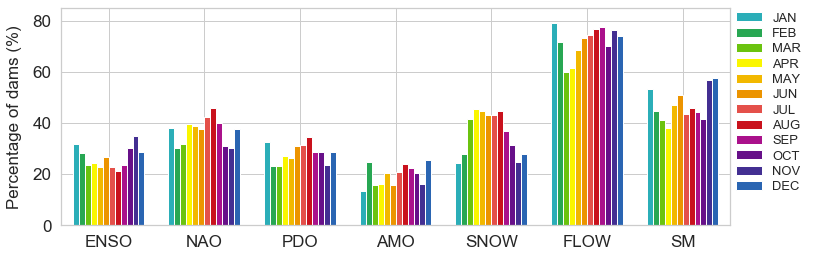

./figures/pdam_correlated.pdf is saved.


In [92]:
dfPrctDams = dfPrctDams.reindex(index = ['ENSO','NAO','PDO','AMO','SNOW','FLOW','SM'])
clist = ['#2BAEB8', '#28A753', '#6BC30F', '#FAF600', '#F2B800', '#EC9400', 
         '#E4504A', '#C9121D', '#AA118B', '#671089', '#432F92', '#2A65B2']
cmap = colors.ListedColormap(clist)

# MultiBar
sns.set(rc={'figure.figsize':(12,4)})
sns.set_style("whitegrid")
ax = dfPrctDams.plot.bar(width=0.75, colormap=cmap)

# Parameters
ax.set_ylim([0,85])
ax.set_xlim([-0.5,6.5])
ax.tick_params(axis='both', which='major', labelsize=17)
ax.set_ylabel('Percentage of dams (%)', fontsize=17, labelpad=10)
plt.xticks(range(0,7), dfPrctDams.index, rotation='horizontal')
# ax.legend(loc='upper right',bbox_to_anchor=(1.15,1.05), fontsize=13, frameon=False)
lg = plt.legend(loc='upper right',bbox_to_anchor=(1.123,1.034), fontsize=13, frameon=False,
                labelspacing = 0.25)
# for t in lg.get_texts():
#     t.set_ha('center')
#     t.set_position((10,0))
# lg.legendHandles[0]._sizes= 30

plt.tight_layout
plt.show()
if True:
    fn_save = './figures/pdam_correlated.pdf'
    ax.figure.savefig(fn_save, bbox_inches='tight')
    print('%s is saved.' % fn_save)
    fn_save = './figures/pdam_correlated.png'
    ax.figure.savefig(fn_save, bbox_inches='tight')